In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 980 images belonging to 2 classes.
Training for fold 1
94765736/94765736 [==============================] - 1s 0us/step
Found 882 images belonging to 2 classes.
Found 98 images belonging to 2 classes.
Epoch 1/10
27/27 [==============================] - 209s 7s/step - loss: 0.7074 - accuracy: 0.5247 - precision: 0.5247 - recall: 0.5247 - f1_score: 0.5261 - val_loss: 0.6887 - val_accuracy: 0.5521 - val_precision: 0.5521 - val_recall: 0.5521 - val_f1_score: 0.5521
Epoch 2/10
27/27 [==============================] - 83s 3s/step - loss: 0.7009 - accuracy: 0.4753 - precision: 0.4753 - recall: 0.4753 - f1_score: 0.4721 - val_loss: 0.6778 - val_accuracy: 0.5104 - val_precision: 0.5104 - val_recall: 0.5104 - val_f1_score: 0.5104
Epoch 3/10
27/27 [==============================] - 81s 3s/step - loss: 0.6874 - accuracy: 0.5282 - precision: 0.5282 - recall: 0.5282 - f1_score: 0.5305 - val_loss: 0.6818 - val_accuracy: 0.5417 - val_precision: 0.5417 - val_recall: 0.5417 - val_f1_score: 0.5417


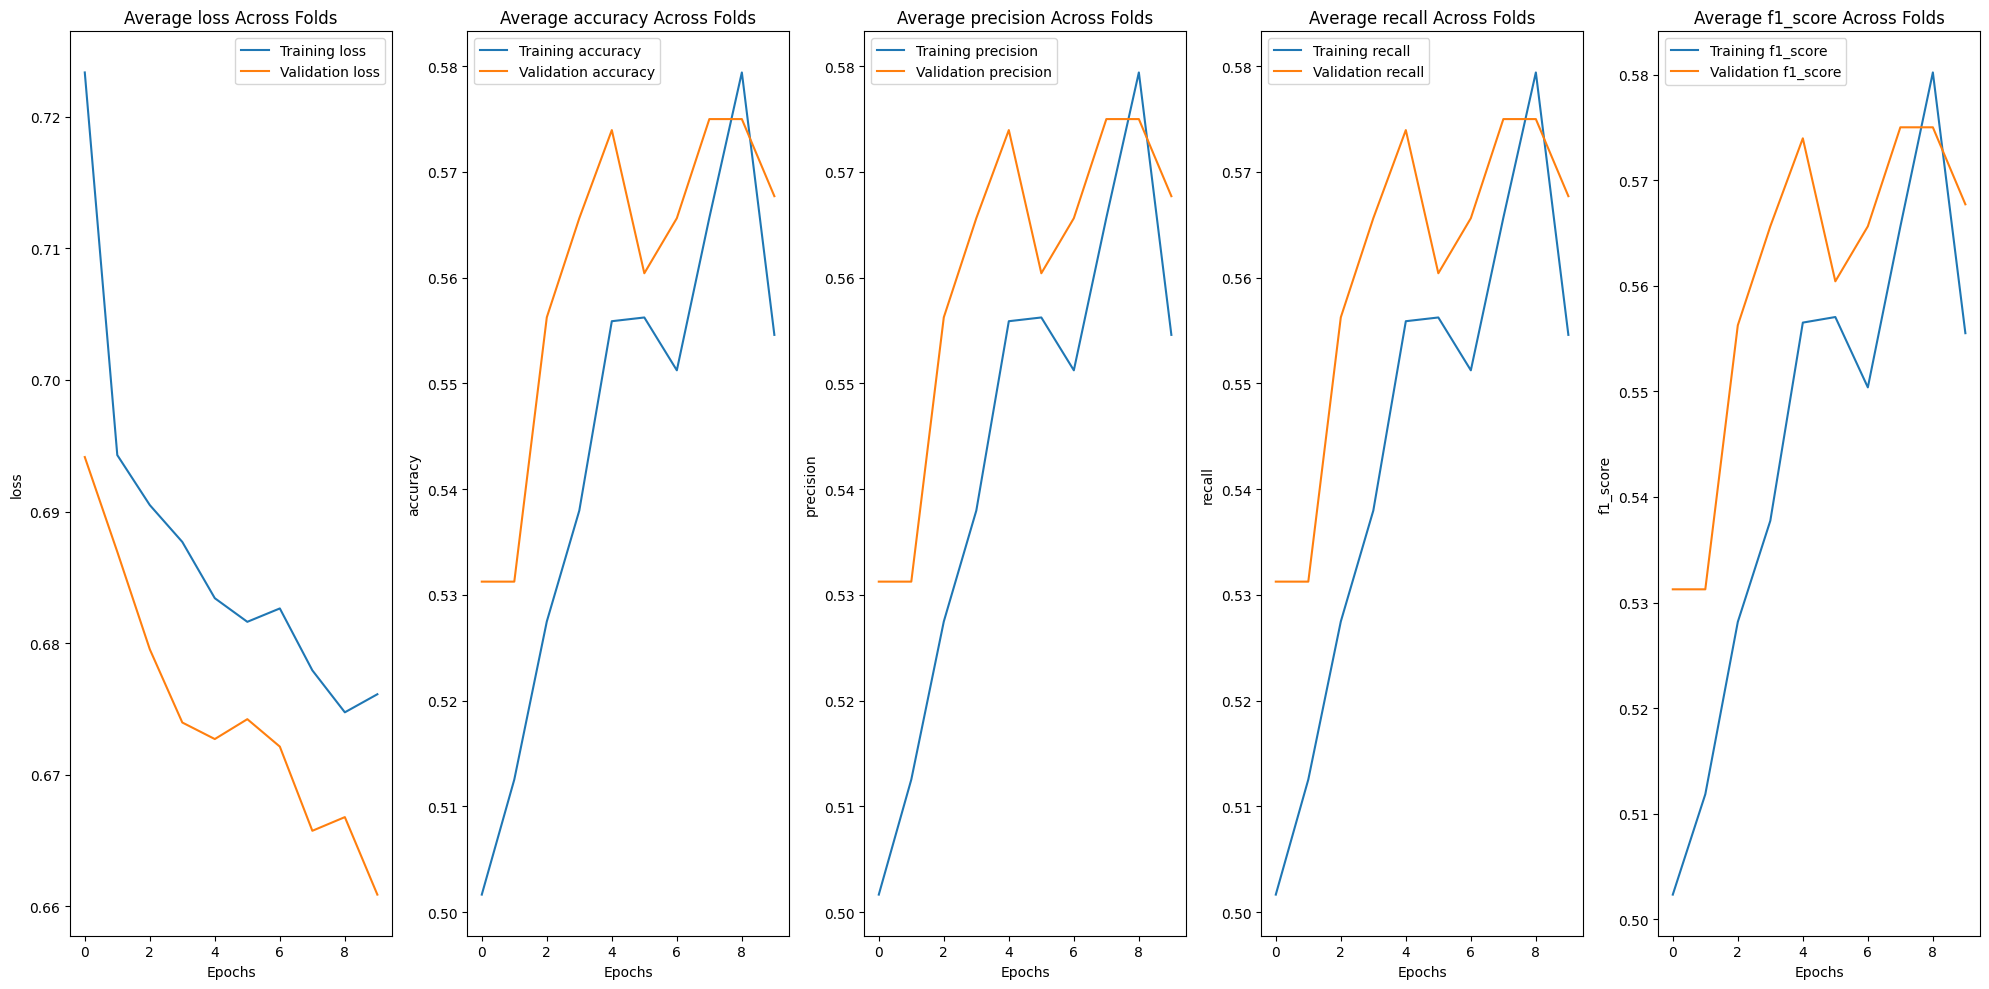

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import backend as K

# Custom F1-score metric
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision + recall + K.epsilon())
    return f1_val

# Defining data directories
validation_path = '/content/drive/MyDrive/Dataset/Validiation'
train_dir = '/content/drive/MyDrive/Dataset/Train'
test_dir = '/content/drive/MyDrive/Dataset/Test'

# Setting constants and hyperparameters
batch_size = 32
image_size = (224, 224)
num_classes = 2
epochs = 10
k_folds = 10

# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1)

# Data generator for training
data_generator = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

# Initialize K-Fold cross-validation
kf = KFold(n_splits=k_folds)
fold_num = 1
histories = []

# K-Fold Cross-Validation
for train_index, val_index in kf.split(np.zeros(data_generator.samples), np.zeros(data_generator.samples)):
    print(f"Training for fold {fold_num}")

    # Build model using ResNet50 as base
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
    resnet_base.trainable = False
    x = resnet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=resnet_base.input, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), f1_score])

    # Data generators for this fold
    train_subset_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset="training",
        seed=fold_num)

    val_subset_generator = datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset="validation",
        seed=fold_num)

    # Train model on this fold
    history = model.fit(
        train_subset_generator,
        steps_per_epoch=train_subset_generator.samples // batch_size,
        validation_data=val_subset_generator,
        validation_steps=val_subset_generator.samples // batch_size,
        epochs=epochs)

    histories.append(history)
    fold_num += 1

# Test the model
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

test_metrics = model.evaluate(test_generator)
print(f"Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}, Test Precision: {test_metrics[2]}, Test Recall: {test_metrics[3]}, Test F1 Score: {test_metrics[4]}")

# Plotting
metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
plt.figure(figsize=(20, 10))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(1, len(metrics_to_plot), i+1)
    avg_train_metric = np.mean([history.history[metric] for history in histories], axis=0)
    avg_val_metric = np.mean([history.history['val_' + metric] for history in histories], axis=0)

    plt.plot(avg_train_metric, label=f'Training {metric}')
    plt.plot(avg_val_metric, label=f'Validation {metric}')
    plt.title(f"Average {metric} Across Folds")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()
